# W2M5

이번 미션에서는 트위터 데이터를 받아와서 자주 나오는 단어를 word cloud로 출력합니다.

## Prepare
우선 주요 모듈을 다운로드 받습니다.

In [ ]:
! pip install wordcloud
! pip install nltk
! pip install pandas

#import nltk
#nltk.download('all')

다음으로는 X(전 트위터) 데이터를 다운로드 받습니다.

In [ ]:
! pwd
! curl -L -o ./sentiment140.zip\
  https://www.kaggle.com/api/v1/datasets/download/kazanova/sentiment140
! unzip sentiment140.zip

다음으로는 이번 미션에 필요한 모듈을 받아옵니다.

In [1]:
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import nltk
import tqdm

mp.set_start_method('fork', force=True) # setting multi-processing

## Extract and Transform
데이터를 csv로부터 읽고 단어단위로 변환합니다.

우선 멀티프로세싱을 위한 함수를 선언하고 정의합니다.

In [4]:
def work(data):
    # set tools to transform from sentence to refined word
    stop_words = set(nltk.corpus.stopwords.words('english'))
    stop_words.update(["..."])
    gTokens = []
    lmtzr = nltk.stem.WordNetLemmatizer()
    stemmer = nltk.stem.PorterStemmer()
    print(mp.current_process().pid, len(data))

    #transform
    for sentence in tqdm.tqdm(data["text"], desc="tokenizing"):
        tokens = [t for t in nltk.word_tokenize(sentence)]
        tokens = [t for t in tokens if t not in stop_words]
        tokens = [t for t in tokens if len(t) >= 3]
        tokens = [t.lower() for t in tokens]
        tokens = [lmtzr.lemmatize(t, 'v') for t in tokens]
        tokens = [stemmer.stem(t) for t in tokens]
        [gTokens.append(t) for t in tokens if t != "n't"]
    return pd.Series(gTokens)

다음으로는 메인 프로세스에서 데이터를 읽고, 나눠서 멀티 프로세싱으로 데이터를 변환합니다. 변환은 간단하게 긍정, 부정 세트로 나눠서 2개의 프로세스로 진행합니다.

멀티 프로세싱으로 인해 진행률이 다소 이상하게 나올 수 있습니다

In [ ]:
# constants
WORK_CNT = 8
WHOLE_SIZE = 1600000
BATCH_SIZE = 200000

if __name__ == "__main__":
    # extract: read csv from disk
    data = pd.read_csv("training.1600000.processed.noemoticon.csv",
                        encoding='ISO-8859-1',
                        names=["target", "id","date", "flag", "user", "text" ]
                        )

    # transform: tokenize the sentences
    data0 = data[data["target"] == 0]   # negative set
    data4 = data[data["target"] == 4]   # positive set

    data0 = [data0[i:i+BATCH_SIZE] for i in range(0, len(data0), BATCH_SIZE)]
    data4 = [data4[i:i+BATCH_SIZE] for i in range(0, len(data4), BATCH_SIZE)]
    data = data0
    data.extend(data4)
    
    with mp.Pool(processes=WORK_CNT) as p:
        res = p.map(work, data)
    
    data = [[],[]]
    data[0] += [item for sublist in res[:len(res)//2] for item in sublist]
    data[1] += [item for sublist in res[len(res)//2:] for item in sublist]
    res = data

## Print Result
변환 결과를 word cloud 이미지로 출력합니다

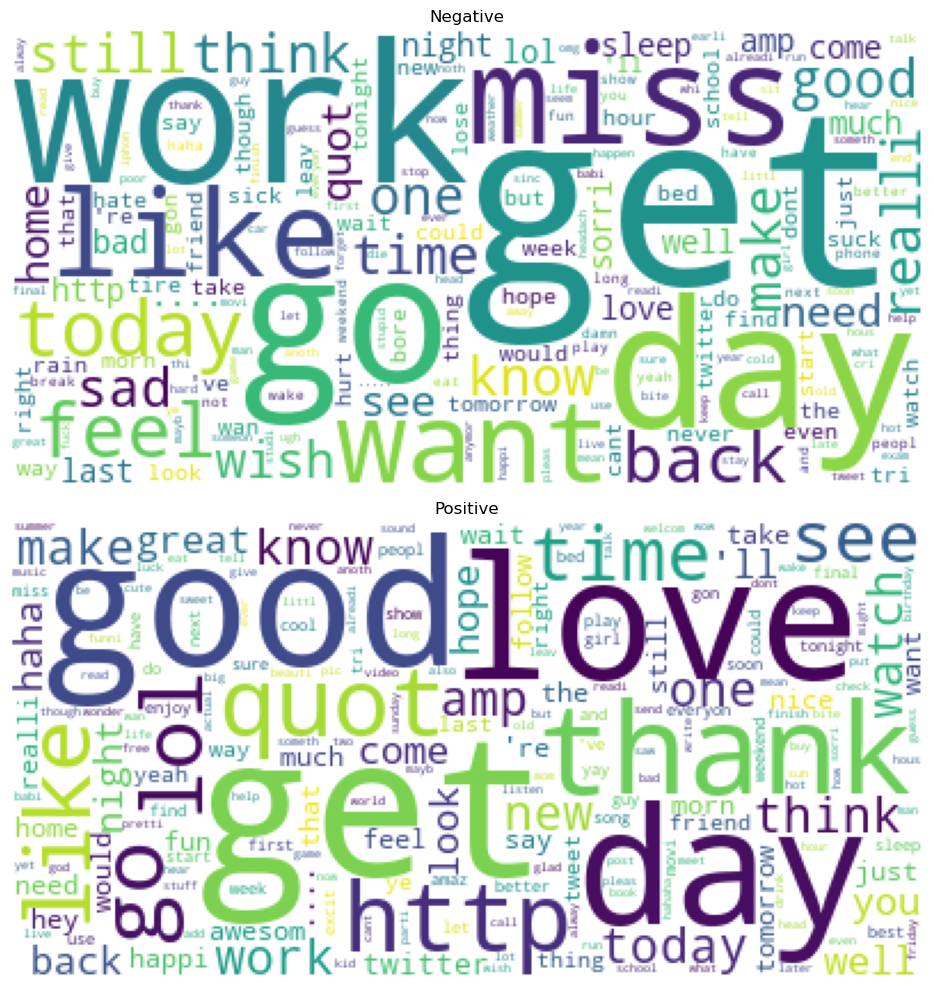

In [13]:
wc = WordCloud(background_color="white")
wc2 = WordCloud(background_color="white")

cloud1 = wc.generate_from_frequencies(pd.Series(res[0].value_counts().head(200))
cloud2 = wc2.generate_from_frequencies(pd.Series(res[1]).value_counts().head(200))

fig, axes = plt.subplots(2, 1, figsize=(10, 10))  # 1행 2열 서브플롯

axes[0].imshow(cloud1)
axes[0].axis('off')
axes[0].set_title('Negative')

axes[1].imshow(cloud2)
axes[1].axis('off')
axes[1].set_title('Positive')

plt.tight_layout()
plt.show()
